In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import math
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image
import os, sys, shutil
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

## EDA

In [4]:
def readDatasetDF(datasetType, rootDir='data/'):
    """
    dataset Type: "train", "val", "test" 
    Return:
        dataframe with image name/label
    """
    df = pd.read_csv('{}/{}-calibrated-shuffled.txt'.format(rootDir, datasetType), header=None, delimiter = " ")
    df[0] = rootDir+"/"+df[0]
    return df

df_tr = readDatasetDF('train')
df_val = readDatasetDF('val')
df_test = readDatasetDF('test')
df_tr.head()

,0,1
0,data//calibrated/0077ML0005780000102730I01_DRC...,15
1,data//calibrated/0072MR0005610170103642E01_DRC...,8
2,data//calibrated/0069MR0004130000103477I01_DRC...,21
3,data//calibrated/0154ML0008510010104492E01_DRC...,8
4,data//calibrated/0019MR0000530000100138C00_DRC...,8


In [5]:
print(df_tr.shape)
print(df_val.shape)
print(df_test.shape)

(3746, 2)
(1640, 2)
(1305, 2)


In [6]:
df_tr[1].value_counts()

8     2343
9      224
23     178
21     166
10     165
14     101
15      85
17      73
24      69
20      57
3       47
5       36
13      36
12      32
0       30
4       19
16      18
2       15
11      14
19      12
7        8
18       8
1        6
6        4
Name: 1, dtype: int64

In [7]:
class_names = pd.read_csv('data/msl_synset_words-indexed.txt', delimiter="      ", header=None, engine='python').set_index(0).to_dict()[1]
for i in class_names.keys():
    class_names[i] = class_names[i].strip()
class_names

{0: 'apxs',
 1: 'apxs cal target',
 2: 'chemcam cal target',
 3: 'chemin inlet open',
 4: 'drill',
 5: 'drill holes',
 6: 'drt front',
 7: 'drt side',
 8: 'ground',
 9: 'horizon',
 10: 'inlet',
 11: 'mahli',
 12: 'mahli cal target',
 13: 'mastcam',
 14: 'mastcam cal target',
 15: 'observation tray',
 16: 'portion box',
 17: 'portion tube',
 18: 'portion tube opening',
 19: 'rems uv sensor',
 20: 'rover rear deck',
 21: 'scoop',
 22: 'sun',
 23: 'turret',
 24: 'wheel'}

In [8]:
img_paths = df_tr.iloc[:, 0].tolist()
rootDir = 'msl-images/'
img = cv2.imread(img_paths[0])

In [9]:
df_tr.iloc[:, 0].tolist()[0]

'data//calibrated/0077ML0005780000102730I01_DRCL.JPG'

In [10]:
plt.imshow(img)

## Preprocessing

The data has few under-sampled classes (under 80), we would like to remove them


In [74]:
#First we combine all datasets
frames = [df_tr, df_val, df_test]
result = pd.concat(frames)
result.reset_index(drop = True, inplace = True)

In [75]:
#omitted classes with less than 80 samples
omit = [0, 20, 19, 13, 6, 4, 2, 11, 1, 18]
omit_index = []
for index, row in result.iterrows():
    if row[1] in omit:
        omit_index.append(index)
        
result.drop([x for x in omit_index], inplace = True, axis = 0)
result.reset_index(drop = True, inplace = True)

In [76]:
result.head(2)

,0,1
0,data//calibrated/0077ML0005780000102730I01_DRC...,15
1,data//calibrated/0072MR0005610170103642E01_DRC...,8


In [86]:
#Map labels to new numbers
label_map = dict(zip(result[1].unique(), list(range(14))))
new_label_l = []
for x in result.itertuples():
    new_label_l.append(label_map[x[2]])
result[1] = new_label_l

In [114]:
X = result[0]
Y = result[1]

X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify = Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.25, random_state=1, stratify = Y_train_temp)

In [115]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3702,)
(1234,)
(1235,)


In [116]:
train_df = pd.concat([X_train, Y_train], axis=1)
val_df = pd.concat([X_val, Y_val], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)

In [122]:
train_df.to_csv('data/train_df_new.txt', header=None, index=None, sep=' ', mode='a')
val_df.to_csv('data/val_df_new.txt', header=None, index=None, sep=' ', mode='a')
test_df.to_csv('data/test_df_new.txt', header=None, index=None, sep=' ', mode='a')

In [123]:
batch_size = 32
img_height = 256
img_width = 256
path = 'data/'

train_dir = path + '/train_df_new.txt'
validation_dir = path + '/val_df_new.txt'
test_dir = path + '/test_df_new.txt'

def read_dataset(dir):
    df = pd.read_csv(dir, header=None, delimiter = " ")
    df[0] = df[0]
    image_paths = df[0].values
    labels = df[1].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    return dataset

train_ds = read_dataset(train_dir)
val_ds = read_dataset(validation_dir)
test_ds = read_dataset(test_dir)

def read_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    #image = (image / 255.0)
    return image, label 

def augment(image_label, seed): 
    image_path, label = image_label
    image, label = read_image(image_path, label)
    image = tf.image.resize_with_crop_or_pad(image, img_height + 6, img_width + 6)
    # Make a new seed
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random crop back to the original size
    image = tf.image.stateless_random_crop(
        image, size=[img_height, img_width, 3], seed=seed)
    # Random brightness
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    image = tf.image.random_brightness(image, max_delta= 0.05)
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_saturation(image, 0.6, 1.6)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    #image = tf.clip_by_value(image, 0, 1)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_ds, (counter, counter)))
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(read_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(read_image, num_parallel_calls=AUTOTUNE)

In [124]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds =  configure_for_performance(test_ds)

## Generate TFRecords

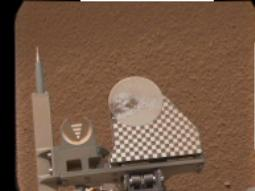

In [148]:
# display.display(display.Image(filename=df_tr[0][0]))

In [125]:
# def _bytes_feature(value):
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def _float_feature(value):
#     return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

# def _int64_feature(value):
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [126]:
# def create_tf_example(filename, label):
#     image_string = open('data/resized'+filename[16:], 'rb').read()
    
#     feature = {
#         'image': _bytes_feature(image_string),          
#         'label': _int64_feature(label),
#     }
#     tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
#     return tf_example

In [ ]:
# for x in df_tr.itertuples():
#     filename = x._1
#     print('data/resized'+filename[16:])
#     break

In [ ]:
# # Write tfrecord for training data
# writer = tf.io.TFRecordWriter("data/out/train.tfrecords")
    
# for x in df_tr.itertuples():
#     filename = x._1
#     label = x._2
#     tf_example = create_tf_example(filename, label)
#     writer.write(tf_example.SerializeToString())

In [131]:
# # Write tfrecord for validation data
# writer = tf.io.TFRecordWriter("data/out/val.tfrecords")
    
# for x in df_val.itertuples():
#     filename = x._1
#     label = x._2
#     tf_example = create_tf_example(filename, label)
#     writer.write(tf_example.SerializeToString())

In [132]:
# # Write tfrecord for test data
# writer = tf.io.TFRecordWriter("data/out/test.tfrecords")
    
# for x in df_test.itertuples():
#     filename = x._1
#     label = x._2
#     tf_example = create_tf_example(filename, label)
#     writer.write(tf_example.SerializeToString())

## Extract Tfrecord

In [133]:
# # Decode the image
# def decode_image(image):
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.cast(image, tf.float32)
#     image = tf.reshape(image, [RESIZE, RESIZE, 3])
#     return image

# # Extract features from tfrecord
# def _extract_fn(tfrecord):
#     feature = {
#         'image': tf.io.FixedLenFeature([], tf.string),
#         'label': tf.io.FixedLenFeature([], tf.int64),
#     }
#     sample = tf.io.parse_single_example(tfrecord, feature)
#     image = decode_image(sample['image'])
#     label = tf.cast(sample['label'], tf.int32)
    
#     return [image, label]

In [134]:
# # Batch dataset
# def batch_dataset(filename, batch_size):
#     dataset = tf.data.TFRecordDataset(filename)
#     dataset = dataset.map(_extract_fn)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
#     return dataset

In [135]:
# BATCH_SIZE = 16

# train_ds = batch_dataset('data/out/train.tfrecords', BATCH_SIZE)
# val_ds = batch_dataset('data/out/val.tfrecords', BATCH_SIZE)
# test_ds = batch_dataset('data/out/test.tfrecords', BATCH_SIZE)

In [136]:
# image_batch, label_batch = next(iter(train_ds))

In [137]:
# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10, 10))
#     for n in range(25):
#         ax = plt.subplot(5, 5, n + 1)
#         plt.imshow(image_batch[n] / 255.0)
#         plt.title(class_names[label_batch[n]])
#         plt.axis("off")


# show_batch(image_batch.numpy(), label_batch.numpy())

## Transfer Learning

In [138]:
# Baseline Resnet50 model
base_model = tf.keras.applications.ResNet50(
    include_top=False, input_shape=(256, 256, 3), weights='imagenet'
)

In [139]:
# Freeze the base
base_model.trainable = False

In [140]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [141]:
num_classes = 14

inputs = tf.keras.layers.Input([256, 256, 3])
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(14, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10

history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Epoch 1/10


/opt/anaconda3/envs/default/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


  6/116 [>.............................] - ETA: 9:58 - loss: 1.7143 - accuracy: 0.5677 

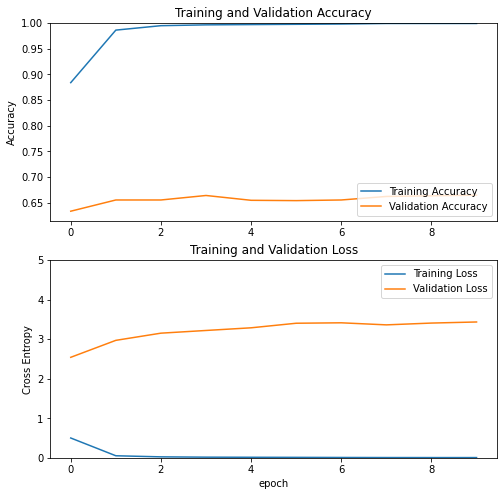

In [249]:
# Learning CUrve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model with image augmentation

In [154]:
RESIZE = 255
BATCH_SIZE = 32

In [155]:
data_augmentation = tf.keras.Sequential([        
    tf.keras.layers.experimental.preprocessing.Rescaling(1./RESIZE),                          
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [156]:
epochs = 100
input_shape = (256,256,3)
# Create base model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    pooling=None,
    classes=25,
    classifier_activation="softmax",
)
# Freeze base model
#base_model.trainable = False
base_model.trainable = True

fine_tune_at = 130

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [157]:
# Create new model on top.
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(25)(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [158]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [159]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [ ]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=3, min_lr=1e-6, mode='min')

In [ ]:
history = model.fit(
    train_ds, 
    epochs= 10, 
    batch_size=BATCH_SIZE, 
    steps_per_epoch=None, 
    validation_data=val_ds, 
    validation_steps=None,
    callbacks=lr_reducer
) 

Epoch 1/10
118/118 [==============================] - 1504s 13s/step - loss: 0.2866 - accuracy: 0.9253 - val_loss: 0.8307 - val_accuracy: 0.8012
Epoch 2/10
118/118 [==============================] - 4266s 36s/step - loss: 0.1093 - accuracy: 0.9738 - val_loss: 0.5722 - val_accuracy: 0.9006
Epoch 3/10
118/118 [==============================] - 1780s 15s/step - loss: 0.0330 - accuracy: 0.9893 - val_loss: 0.4344 - val_accuracy: 0.9250
Epoch 4/10
118/118 [==============================] - 4755s 41s/step - loss: 0.0253 - accuracy: 0.9915 - val_loss: 0.3705 - val_accuracy: 0.9256
Epoch 5/10
118/118 [==============================] - 23146s 198s/step - loss: 0.0158 - accuracy: 0.9955 - val_loss: 0.3291 - val_accuracy: 0.9317
Epoch 6/10
 94/118 [======================>.......] - ETA: 55:51 - loss: 0.0087 - accuracy: 0.9970 

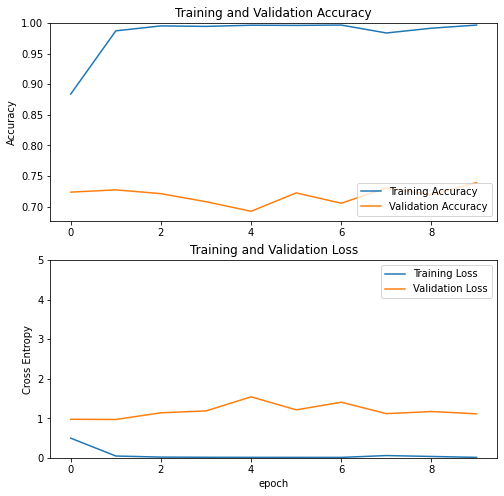

In [41]:
# Learning CUrve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [212]:
pred = model.predict(test_ds)
pred_class = np.argmax(pred, axis=1)

In [213]:
test_label = np.concatenate([y for x, y in test_ds], axis=0)

In [214]:
cf_matrix = confusion_matrix(test_label, pred_class)

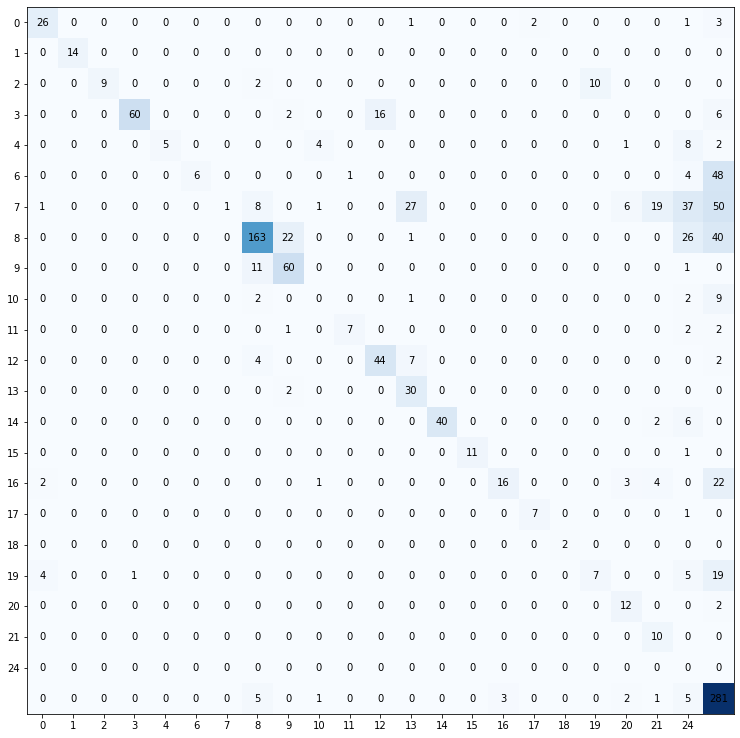

In [215]:
plt.figure(figsize=(13,13))
plt.imshow(cf_matrix, cmap=plt.cm.Blues)

for i in range(23):
    for j in range(23):
        c = cf_matrix[j,i]
        plt.text(i, j, str(c), va='center', ha='center')

ax = plt.xticks(range(22), np.sort(df_test[1].unique()))
ax = plt.yticks(range(22), np.sort(df_test[1].unique()))

## EfficientNet

In [ ]:
model = tf.keras.Sequential([
            efn.EfficientNetB0(
                input_shape=(256, 256, 3),
                weights='imagenet',
                include_top=False),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(25, activation='softmax')
])

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [ ]:
print("Number of layers in the base model: ", len(model.layers))

In [ ]:
len(model.trainable_variables)

In [ ]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=3, min_lr=1e-6, mode='min')

In [ ]:
history = model.fit(train_ds, epochs= 20, callbacks=lr_reducer, validation_data=val_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()